In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os

# Data Reading and Preparation

In [3]:
def compute_metrics(df, title=None):
    df['cumulative_return'] = (1 + df['return']).cumprod()
    df['rolling_max'] = df['cumulative_return'].cummax()
    df['drawdown'] = df['cumulative_return'] / df['rolling_max'] - 1

    max_drawdown_per_year = df.groupby(df.index.year)['drawdown'].min()
    monthly_returns = df['return'].resample('ME').apply(lambda x: (1 + x).prod() - 1)
    worst_month = monthly_returns.idxmin()
    worst_month_return = monthly_returns.min()

    mean = df['return'].mean() * 252
    vol = df['return'].std() * np.sqrt(252)
    sharpe = mean / vol
    skew = df['return'].skew()

    table = pd.DataFrame(
        {
            'Annualized Mean': [mean],
            'Annualized Vol': [vol],
            'Annualized Sharpe': [sharpe],
            'Skew': [skew],
            'Worst Month': [worst_month],
            'Worst Month Return': [worst_month_return],
        },
        index=['']
    )

    return table

In [4]:
df1 = pd.read_csv('macro/flatfiles/bond_equity_btc.csv').rename(columns = {'date':'Date'
                                                                          ,'LUATTRUU Index':'Bond'
                                                                          ,'SPXT Index':'Equity'
                                                                          ,'XBT BGN Curncy':'Bitcoin'})
df1.index = pd.to_datetime(df1.index)
df1.set_index('Date', inplace = True)
df1.dropna(inplace=True)

In [5]:
df2 = pd.read_csv('macro/flatfiles/ltcm_price_data.csv')
df2 = df2[['date','XAUBGN BGN Curncy']].rename(columns = {'date':'Date','XAUBGN BGN Curncy':'Gold'})
df2.index = pd.to_datetime(df2.index)
df2.set_index('Date', inplace = True)
df2.dropna(inplace=True)

In [6]:
df = pd.merge(df1, df2, left_index=True, right_index=True, how='inner')
df

In [ ]:
# Compute daily returns
df['r Bond']    = df['Bond'].pct_change()
df['r Equity']  = df['Equity'].pct_change()
df['r Bitcoin'] = df['Bitcoin'].pct_change()
df['r Gold']    = df['Gold'].pct_change()

df.dropna(inplace=True)
returns = df[['r Bond', 'r Equity', 'r Bitcoin', 'r Gold']]
returns.tail()




,r Bond,r Equity,r Bitcoin,r Gold
Date,,,,
2025-05-13,-0.000981,0.007275,0.018562,-0.004480
2025-05-14,-0.002457,0.001070,-0.009808,-0.021656
2025-05-15,0.004453,0.004381,-0.001062,0.019135
2025-05-16,0.000210,0.007137,0.002404,-0.009376
2025-05-19,-0.000133,0.001022,0.022867,0.001085


In [48]:
returns.corr()

,r Bond,r Equity,r Bitcoin,r Gold
r Bond,1.000000,-0.165295,-0.001765,0.263027
r Equity,-0.165295,1.000000,0.223045,-0.004408
r Bitcoin,-0.001765,0.223045,1.000000,0.055168
r Gold,0.263027,-0.004408,0.055168,1.000000


In [49]:
#equity / bond / gold / BTC 2023&2024; 2025
Metrics_df = pd.DataFrame()
Metrics_df["return"] =  0.6 * df['r Equity']["2023":"2025"]  + 0.4 * df['r Bond']["2023":"2025"]
Metrics_df.index = pd.to_datetime(Metrics_df.index)
port_60_40_0_0 = compute_metrics(Metrics_df, '60-40 / Equity-Bond')

Metrics_df = pd.DataFrame()
Metrics_df["return"] =  0.6 * df['r Equity']["2025":]  + 0.4 * df['r Bond']["2025":]
Metrics_df.index = pd.to_datetime(Metrics_df.index)
port_60_40_0_0_2025 = compute_metrics(Metrics_df, '60-40 / Equity-Bond')

# Concatenate the DataFrames
portfolio_df = pd.concat([port_60_40_0_0,port_60_40_0_0_2025])
portfolio_df.index =["port_60_40_0_0","port_60_40_0_0_2025"]

portfolio_df

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skew,Worst Month,Worst Month Return
port_60_40_0_0,0.152770,0.082303,1.856202,-0.178825,2023-09-30,-0.037412
port_60_40_0_0_2025,0.074461,0.161341,0.461516,1.081603,2025-03-31,-0.032781


## Definition of Key Functions

In [50]:
def portfolio_volatility(weights, cov_matrix):
    """
    Computes the portfolio volatility using the formula:
        volatility = sqrt( w^T * Sigma * w )
    
    Parameters:
        weights (numpy array): Vector of asset weights in the portfolio.
        cov_matrix (numpy array): Covariance matrix of asset returns.
    
    Returns:
        float: Portfolio volatility.
    """
    return np.sqrt(weights.T @ cov_matrix @ weights)

def risk_contributions(weights, cov_matrix):
    """
    Computes the risk contributions of each asset in the portfolio.
    
    Parameters:
        weights (numpy array): Vector of asset weights in the portfolio.
        cov_matrix (numpy array): Covariance matrix of asset returns.
    
    Returns:
        tuple:
            - rc (numpy array): Vector of absolute risk contributions ( w_i * MC_i ).
            - mc (numpy array): Vector of marginal risks = (Sigma * w) / sigma_p.
    """
    sigma_p = portfolio_volatility(weights, cov_matrix)
    mc = (cov_matrix @ weights) / sigma_p  # Marginal contributions
    rc = weights * mc                      # Risk contributions
    return rc, mc

def risk_budget_objective(weights, cov_matrix, risk_budgets):
    """
    Objective function for optimization:
      Minimize the sum of squared differences between 
      relative risk contributions (RC_i / sigma_p) and the desired budget (b_i).

    Implements: sum((RC_rel_i - b_i)^2)

    Parameters:
        weights (numpy array): Vector of asset weights in the portfolio.
        cov_matrix (numpy array): Covariance matrix of asset returns.
        risk_budgets (numpy array): Desired relative risk budget for each asset.

    Returns:
        float: Value of the objective function to be minimized.
    """
    rc, _ = risk_contributions(weights, cov_matrix)
    sigma_p = np.sum(rc)  # Equivalent to total volatility using the previous formula
    rc_rel = rc / sigma_p
    return np.sum((rc_rel - risk_budgets)**2)

def optimize_risk_budget(cov_matrix, risk_budgets, 
                         constraint_btc_gold=True, idx_btc=None, idx_gold=None):
    """
    Solves the 'Risk Budgeting' optimization problem with constraints:
      - sum(weights) = 1
      - 0 <= weights[i] <= 1
      - (Optional) weights[BTC] + weights[Gold] <= 0.20
        (if constraint_btc_gold=True and idx_btc, idx_gold are provided)

    Parameters:
        cov_matrix (numpy array): Covariance matrix of asset returns.
        risk_budgets (numpy array): Desired relative risk budget for each asset.
        constraint_btc_gold (bool, optional): Whether to apply the BTC + Gold weight constraint. Default is True.
        idx_btc (int, optional): Index of Bitcoin in the weights vector.
        idx_gold (int, optional): Index of Gold in the weights vector.

    Returns:
        numpy array: Optimized asset weights that satisfy the risk budgeting constraints.
    """
    n = len(risk_budgets)
    
    # Constraint: sum of all weights must equal 1
    cons = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
    
    # If requested, add the constraint x_BTC + x_GOLD <= 0.20
    if constraint_btc_gold and (idx_btc is not None) and (idx_gold is not None):
        cons.append({'type': 'ineq', 
                     'fun': lambda w: 0.20 - (w[idx_btc] + w[idx_gold])})

    # Bounds: Each weight must be between [0,1]
    bnds = [(0,1)] * n

    # Initialize with equal weights (1/n)
    x0 = np.ones(n) / n
    
    result = minimize(
        fun=risk_budget_objective,
        x0=x0,
        args=(cov_matrix, risk_budgets),
        method='SLSQP',
        bounds=bnds,
        constraints=cons,
        options={'maxiter': 1000, 'ftol': 1e-12}
    )
    return result.x

# Function to annualize a daily return (assuming ~252 trading days)
def annualized_return(daily_mean_return):
    return daily_mean_return * 252 


Minimize the sum of squared differences between:
- The **actual relative risk contribution** of each asset: RC_i/sigma_p
- The **desired risk budget**:  b_i

Mathematically, it minimizes:

$
\sum_{i} \left( \frac{RC_i}{\sigma_p} - b_i \right)^2
$



## Calculation of Return Statistics

In [51]:
Sigma = returns["2023":"2025"].cov().values  # Covariance matrix
mu    = returns["2023":"2025"].mean().values # Average daily returns

assets = ['Bond', 'Equity', 'Bitcoin', 'Gold']
idx_btc  = assets.index('Bitcoin')
idx_gold = assets.index('Gold')

In [52]:
# Calculate daily volatility (standard deviation of each asset)
vol_daily = np.sqrt(np.diag(Sigma))  # Square root of the diagonal of the covariance matrix
vol_annual = vol_daily * np.sqrt(252)  # Convert to annualized volatility

# Risk-free rate (assuming 0%)
risk_free_rate = 0

# Calculate the Sharpe Ratio for each asset
sharpe_ratios = (mu * 252 - risk_free_rate) / vol_annual

# Create a dictionary with the results
sharpe_dict = {asset: sharpe for asset, sharpe in zip(assets, sharpe_ratios)}

# Display the Sharpe Ratios for each asset
print("Sharpe Ratios:")
for asset, sharpe in sharpe_dict.items():
    print(f"{asset}: {sharpe:.2f}")

Sharpe Ratios:
Bond: 0.40
Equity: 1.85
Bitcoin: 1.94
Gold: 1.56


**Summary of Asset Performance (2023&2024)**

Based on the analysis of daily returns over the period from January 2023 to December 2024, Bitcoin delivered the highest risk-adjusted returns, with a Sharpe Ratio of 1.94. Equity closely followed, achieving a Sharpe Ratio of 1.85. Gold also provided solid performance (1.56), whereas Bonds significantly lagged, showing a relatively low Sharpe Ratio of 0.40.

This analysis indicates that during 2023 and 2024, Bitcoin and Equity were particularly effective at generating returns relative to their associated risks. Conversely, Bonds underperformed considerably, offering limited returns per unit of volatility, highlighting their comparatively weaker investment appeal over this two-year period.

## If we allocate in BTC

In [53]:
grid_alpha = np.linspace(0, 1, 300)  
results_BTC = []

for alpha in grid_alpha:
    # Compute the fraction of risk to allocate to BTC:
    # The "rule" is: alpha * 0.1 (but capped at 0.1).
    b_btc = min(alpha * .6, 1)
    
    # The remaining budget (1 - b_btc) is distributed as:
    # - 60% to Equity
    # - 40% to Bonds
    # remaining_budget = 1.0 - b_btc
    b_equity = 0.6 - b_btc
    b_bond   = 0.4 #* remaining_budget
    b_gold   = 0.0  # Keep Gold at 0 for this example

    # Ensure the sum equals 1
    total_budget = b_bond + b_equity + b_btc + b_gold
    b_bond   /= total_budget
    b_equity /= total_budget
    b_btc    /= total_budget
    b_gold   /= total_budget

    # This is the risk budget vector we want to achieve:
    rb = np.array([b_bond, b_equity, b_btc, b_gold])

    print(rb)
    # Optimization to find the optimal weight allocation
    w_opt = optimize_risk_budget(Sigma, rb, constraint_btc_gold=False)
    
    # Compute return (daily and then annualized) and volatility (daily and annual)
    port_ret_daily = w_opt @ mu  
    ret_annual = annualized_return(port_ret_daily)
    vol_daily  = portfolio_volatility(w_opt, Sigma)
    vol_annual = vol_daily * np.sqrt(252)

    # Store the results
    results_BTC.append({
        'alpha'       : alpha,
        'BTC_risk'    : b_btc,      # Percentage of risk allocated to BTC
        'weights_opt' : w_opt,      # Optimal weights found
        'ret_annual'  : ret_annual,
        'vol_annual'  : vol_annual
    })


[0.4 0.6 0.  0. ]
[0.4        0.59799331 0.00200669 0.        ]
[0.4        0.59598662 0.00401338 0.        ]
[0.4        0.59397993 0.00602007 0.        ]
[0.4        0.59197324 0.00802676 0.        ]
[0.4        0.58996656 0.01003344 0.        ]
[0.4        0.58795987 0.01204013 0.        ]
[0.4        0.58595318 0.01404682 0.        ]
[0.4        0.58394649 0.01605351 0.        ]
[0.4       0.5819398 0.0180602 0.       ]
[0.4        0.57993311 0.02006689 0.        ]
[0.4        0.57792642 0.02207358 0.        ]
[0.4        0.57591973 0.02408027 0.        ]
[0.4        0.57391304 0.02608696 0.        ]
[0.4        0.57190635 0.02809365 0.        ]
[0.4        0.56989967 0.03010033 0.        ]
[0.4        0.56789298 0.03210702 0.        ]
[0.4        0.56588629 0.03411371 0.        ]
[0.4       0.5638796 0.0361204 0.       ]
[0.4        0.56187291 0.03812709 0.        ]
[0.4        0.55986622 0.04013378 0.        ]
[0.4        0.55785953 0.04214047 0.        ]
[0.4        0.55585284 0

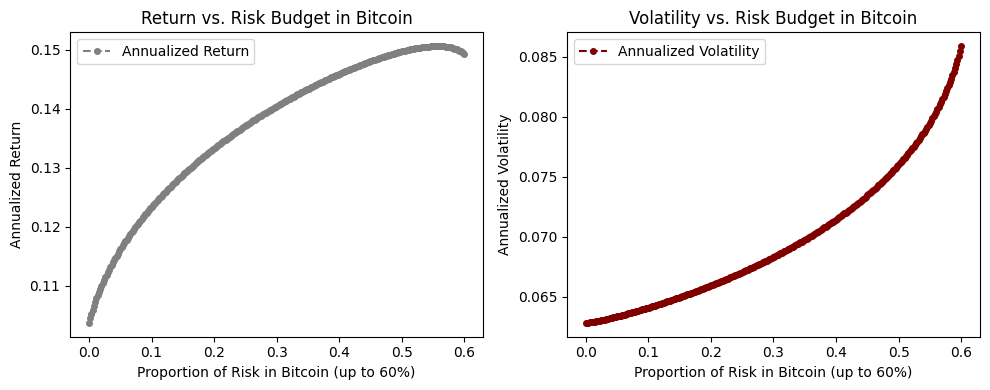

In [54]:
btc_risk_allocations = [res['BTC_risk'] for res in results_BTC]  # X-axis
retsBTC              = [res['ret_annual'] for res in results_BTC]
volsBTC              = [res['vol_annual'] for res in results_BTC]

plt.figure(figsize=(10, 4))

# Subplot: Return vs. Risk Allocation to BTC
plt.subplot(1, 2, 1)
plt.plot(btc_risk_allocations, retsBTC, 'o--', color='gray', label="Annualized Return", markersize=4)
plt.xlabel('Proportion of Risk in Bitcoin (up to 60%)')
plt.ylabel('Annualized Return')
plt.title('Return vs. Risk Budget in Bitcoin')
plt.legend()

# Subplot: Volatility vs. Risk Allocation to BTC
plt.subplot(1, 2, 2)
plt.plot(btc_risk_allocations, volsBTC, 'o--', color='maroon', label="Annualized Volatility", markersize=4)
plt.xlabel('Proportion of Risk in Bitcoin (up to 60%)')
plt.ylabel('Annualized Volatility')
plt.title('Volatility vs. Risk Budget in Bitcoin')
plt.legend()

plt.tight_layout()
plt.show()


**Interpretation of Results: Allocating Risk Budget to Bitcoin**

The plots presented here illustrate the effect of gradually increasing Bitcoin’s share in the portfolio’s total risk budget, specifically evaluating how returns and volatility evolve as Bitcoin’s risk contribution rises from 0% to 60%.

**Return Analysis (Left plot)**

The plot of Annualized Return against Bitcoin’s risk budget clearly indicates an increasing, but gradually flattening, return curve. Initially, allocating a small proportion of risk to Bitcoin significantly enhances portfolio returns. However, as Bitcoin’s risk allocation grows beyond approximately 30-40%, each additional unit of risk allocated to Bitcoin provides increasingly diminished incremental returns. This diminishing marginal benefit suggests that, although adding Bitcoin substantially boosts returns at first, its effectiveness gradually tapers as risk exposure becomes substantial.

**Volatility Analysis (Right plot)**

The plot of Annualized Volatility demonstrates that the portfolio’s volatility increases in a pronounced, accelerating manner with the Bitcoin risk budget. The volatility curve starts relatively flat, indicating minimal additional volatility for small Bitcoin allocations. Nevertheless, beyond approximately 20-30% of the risk budget, volatility sharply increases. Thus, higher allocations to Bitcoin significantly amplify portfolio risk, indicating a clear trade-off between incremental returns and sharply escalating risk.

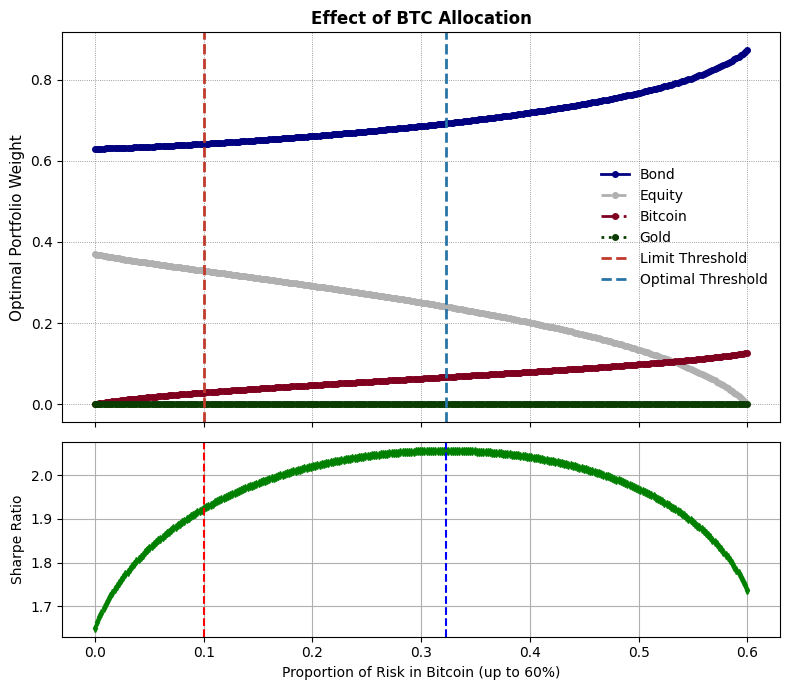


=== Optimal Sharpe Ratio Point ===
Proportion of Risk in Bitcoin: 0.3231
Maximum Sharpe Ratio: 2.0563
Asset allocation weights at Optimal Threshold:
  Bond: 69.2300%
  Equity: 24.0593%
  Bitcoin: 6.7107%
  Gold: 0.0000%

=== Limit Threshold (BTC risk = 10%) ===
Proportion of Risk in Bitcoin: 0.1003
Sharpe Ratio at Limit Threshold: 1.9241
Asset allocation weights at Limit Threshold:
  Bond: 64.1947%
  Equity: 32.9043%
  Bitcoin: 2.9010%
  Gold: 0.0000%


In [55]:
weights_mat = np.array([res['weights_opt'] for res in results_BTC])  # shape: (len(grid), 4)

# Calculate Sharpe Ratios
risk_free_rate = 0  
sharpe_ratios = [(ret - risk_free_rate) / vol for ret, vol in zip(retsBTC, volsBTC)]

# Thresholds
limit_threshold = 0.1  # Risk allocation limit
optimal_threshold_index = np.argmax(sharpe_ratios)  # Index of the maximum Sharpe ratio
optimal_threshold = btc_risk_allocations[optimal_threshold_index]  # Corresponding value


# Create figure and axes
fig, axs = plt.subplots(2, 1, figsize=(8, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

line_styles = ['-', '--', '-.', ':']  # Different line styles
colors = ["#000080", "#B0B0B0", "#800020", "#0B3D02"]

# Plot the evolution of optimal weights
for i, (asset, color, style) in enumerate(zip(assets, colors, line_styles)):
    axs[0].plot(btc_risk_allocations, weights_mat[:, i], marker='o', linestyle=style, 
                color=color, linewidth=2, label=asset, markersize=4)

# Customize the chart
axs[0].set_ylabel('Optimal Portfolio Weight', fontsize=11)
axs[0].set_title('Effect of BTC Allocation', fontsize=12, fontweight='bold')
axs[0].axvline(limit_threshold, color='#C0392B', linestyle='--', linewidth=2, label="Limit Threshold")  # Dark red
axs[0].axvline(optimal_threshold, color='#2874A6', linestyle='--', linewidth=2, label="Optimal Threshold")  # Refined blue
axs[0].legend(frameon=False, fontsize=10)
axs[0].grid(color="gray", linestyle=":", linewidth=0.6)
axs[0].tick_params(labelbottom=False)  # Hide X-axis labels on the top plot

# Plot the Sharpe Ratio
axs[1].plot(btc_risk_allocations, sharpe_ratios, 'd--', color='green', label="Sharpe Ratio", markersize=4)
axs[1].axvline(limit_threshold, color='red', linestyle='--', label="Limit Threshold")
axs[1].axvline(optimal_threshold, color='blue', linestyle='--', label="Optimal Threshold")
axs[1].set_xlabel('Proportion of Risk in Bitcoin (up to 60%)')
axs[1].set_ylabel('Sharpe Ratio')

axs[1].grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print detailed information for Optimal Threshold (Maximum Sharpe Ratio)
optimal_weights = weights_mat[optimal_threshold_index]
optimal_sharpe = sharpe_ratios[optimal_threshold_index]

print("\n=== Optimal Sharpe Ratio Point ===")
print(f"Proportion of Risk in Bitcoin: {optimal_threshold:.4f}")
print(f"Maximum Sharpe Ratio: {optimal_sharpe:.4f}")
print("Asset allocation weights at Optimal Threshold:")
for asset, weight in zip(assets, optimal_weights):
    print(f"  {asset}: {weight:.4%}")

# Print detailed information for Limit Threshold (0.1 BTC Risk Allocation)
limit_index = np.argmin(np.abs(np.array(btc_risk_allocations) - limit_threshold))
limit_weights = weights_mat[limit_index]
limit_sharpe = sharpe_ratios[limit_index]

print("\n=== Limit Threshold (BTC risk = 10%) ===")
print(f"Proportion of Risk in Bitcoin: {btc_risk_allocations[limit_index]:.4f}")
print(f"Sharpe Ratio at Limit Threshold: {limit_sharpe:.4f}")
print("Asset allocation weights at Limit Threshold:")
for asset, weight in zip(assets, limit_weights):
    print(f"  {asset}: {weight:.4%}")

In [56]:
df_weights = pd.DataFrame(weights_mat, columns=assets)  
df_weights.insert(0, "BTC Risk Allocation", btc_risk_allocations)  
df_weights = df_weights.round(3)
df_weights = df_weights.set_index("BTC Risk Allocation")
df_weights

,Bond,Equity,Bitcoin,Gold
BTC Risk Allocation,,,,
0.000,0.630,0.370,0.000,0.0
0.002,0.630,0.369,0.001,0.0
0.004,0.630,0.368,0.002,0.0
0.006,0.630,0.367,0.003,0.0
0.008,0.630,0.366,0.004,0.0
...,...,...,...,...
0.592,0.857,0.020,0.123,0.0
0.594,0.860,0.015,0.124,0.0
0.596,0.864,0.011,0.125,0.0


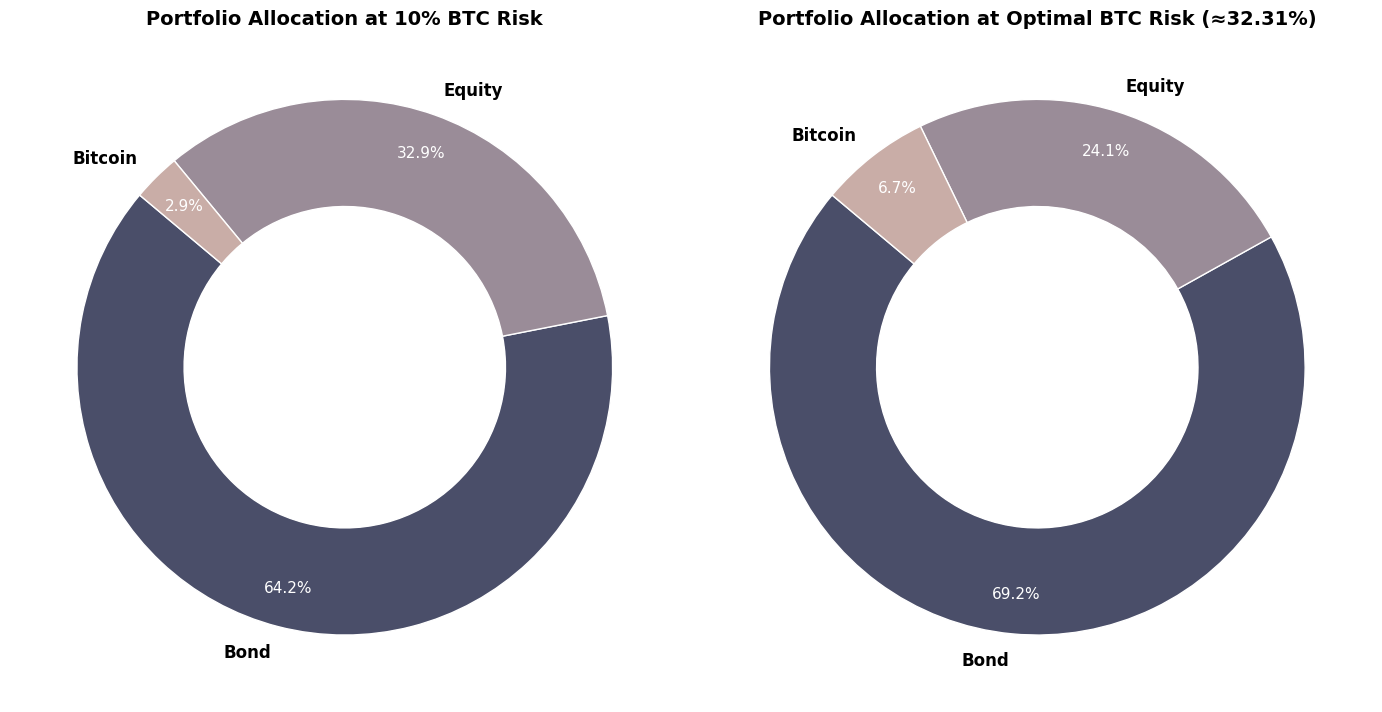

In [57]:
limit_row_data = df_weights.loc[0.1]
limit_row_data_nonzero = limit_row_data[limit_row_data > 0]

optimal_row_data = df_weights.loc[0.323]
optimal_row_data_nonzero = optimal_row_data[optimal_row_data > 0]

colors = ["#4A4E69", "#9A8C98", "#C9ADA7", "#22223B"]

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

wedges1, texts1, autotexts1 = axs[0].pie(
    limit_row_data_nonzero,
    labels=limit_row_data_nonzero.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='white'),
    pctdistance=0.85
)

axs[0].set_title("Portfolio Allocation at 10% BTC Risk", fontsize=14, fontweight='bold')
plt.setp(texts1, fontsize=12, fontweight='bold')
plt.setp(autotexts1, fontsize=11, color='white')

centre_circle1 = plt.Circle((0, 0), 0.60, fc='white')
axs[0].add_artist(centre_circle1)

wedges2, texts2, autotexts2 = axs[1].pie(
    optimal_row_data_nonzero,
    labels=optimal_row_data_nonzero.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='white'),
    pctdistance=0.85
)

axs[1].set_title("Portfolio Allocation at Optimal BTC Risk (≈32.31%)", fontsize=14, fontweight='bold')
plt.setp(texts2, fontsize=12, fontweight='bold')
plt.setp(autotexts2, fontsize=11, color='white')

centre_circle2 = plt.Circle((0, 0), 0.60, fc='white')
axs[1].add_artist(centre_circle2)

plt.tight_layout()
plt.show()

**Analysis of Portfolio Allocation with Increasing Bitcoin Risk Contribution**

The analysis presented explores how optimal portfolio allocation and risk-adjusted returns (measured by the Sharpe Ratio) evolve as the proportion of total portfolio risk allocated specifically to Bitcoin (BTC) increases from 0% up to 60%. The first figure demonstrates the optimal weights of each asset—Bond, Equity, Bitcoin, and Gold(set to 0 in this case)—across varying levels of Bitcoin risk contribution. Additionally, the accompanying Sharpe Ratio plot illustrates how portfolio efficiency changes in response to altering Bitcoin’s role in the portfolio.

To determine the optimal asset allocations, we employed a risk-budgeting optimization approach. Initially, the portfolio was set with a risk budget of 60% Equity and 40% Bonds, without any Bitcoin or Gold allocation. As Bitcoin’s risk contribution progressively increased, we reduced the Equity risk allocation proportionally, keeping Bond’s risk budget fixed at 40%, while Gold remained consistently at zero. At each incremental step, the asset weights were numerically optimized to match as closely as possible the predefined risk budgets, ensuring that the realized relative risk contributions matched these targets.

Two critical allocation points were further analyzed:

- **Limit Threshold (10% Bitcoin Risk)**

At a 10% risk allocation to Bitcoin, the portfolio achieves a Sharpe Ratio of approximately 1.9241. The optimal asset weights at this point are approximately 64.2% Bonds, 32.9% Equity, and 2.9% Bitcoin (with negligible Gold). This illustrates a cautious inclusion of Bitcoin, maintaining overall portfolio stability.

- **Optimal Threshold (Maximum Sharpe Ratio, ~32.31% Bitcoin Risk)**

At this optimal level of Bitcoin risk allocation (around 32.31%), the Sharpe Ratio peaks at approximately 2.0563. Here, the optimal portfolio allocation adjusts to approximately 69.2% Bonds, 24.1% Equity, and 6.7% Bitcoin, again with no significant Gold position. This highlights the clear advantage of a moderate Bitcoin inclusion strategy, optimizing the balance between portfolio return and risk.

The final figure, represented by the two donut charts, visually summarizes the asset allocation at these two critical thresholds. This representation clearly underscores how increasing Bitcoin’s proportion of total risk affects the distribution of asset weights within the portfolio, reinforcing Bonds’ stabilizing influence, while carefully leveraging Bitcoin’s high volatility to enhance returns.

In conclusion, this analysis demonstrates that introducing a carefully controlled Bitcoin allocation can meaningfully improve portfolio performance, provided that its risk contribution is strategically optimized rather than excessively expanded.

## If we allocate in Gold

In [58]:
grid_alpha = np.linspace(0, 1, 300)  # 0, 0.1, 0.2, ..., 1.0
results_GOLD = []

for alpha in grid_alpha:
    # Compute the fraction of risk to allocate to BTC:
    # The "rule" is: alpha * 0.1 (but capped at 0.1).
    b_gold = min(alpha * 0.4, 1)

    # - 50% to Equity
    # - 10% to BTC
    # - 40% to Bonds and Gold
    # remaining_budget = 1.0 - b_btc
    b_equity = 0.5
    b_bond   = 0.4   - b_gold  #* remaining_budget
    b_btc   = 0.1  # Keep Gold at 0 for this example

    # Ensure the sum equals 1
    total_budget = b_bond + b_equity + b_btc + b_gold
    b_bond   /= total_budget
    b_equity /= total_budget
    b_btc    /= total_budget
    b_gold   /= total_budget

    # This is the risk budget vector we want to achieve:
    rb = np.array([b_bond, b_equity, b_btc, b_gold])

    print(rb)
    # Optimization to find the optimal weight allocation
    w_opt = optimize_risk_budget(Sigma, rb, constraint_btc_gold=False)
    
    # Compute return (daily and then annualized) and volatility (daily and annual)
    port_ret_daily = w_opt @ mu  
    ret_annual = annualized_return(port_ret_daily)
    vol_daily  = portfolio_volatility(w_opt, Sigma)
    vol_annual = vol_daily * np.sqrt(252)

    # Store the results
    results_GOLD.append({
        'alpha'       : alpha,
        'GOLD_risk'    : b_gold,      # Percentage of risk allocated to BTC
        'weights_opt' : w_opt,      # Optimal weights found
        'ret_annual'  : ret_annual,
        'vol_annual'  : vol_annual
    })


[0.4 0.5 0.1 0. ]
[0.39866221 0.5        0.1        0.00133779]
[0.39732441 0.5        0.1        0.00267559]
[0.39598662 0.5        0.1        0.00401338]
[0.39464883 0.5        0.1        0.00535117]
[0.39331104 0.5        0.1        0.00668896]
[0.39197324 0.5        0.1        0.00802676]
[0.39063545 0.5        0.1        0.00936455]
[0.38929766 0.5        0.1        0.01070234]
[0.38795987 0.5        0.1        0.01204013]
[0.38662207 0.5        0.1        0.01337793]
[0.38528428 0.5        0.1        0.01471572]
[0.38394649 0.5        0.1        0.01605351]
[0.3826087 0.5       0.1       0.0173913]
[0.3812709 0.5       0.1       0.0187291]
[0.37993311 0.5        0.1        0.02006689]
[0.37859532 0.5        0.1        0.02140468]
[0.37725753 0.5        0.1        0.02274247]
[0.37591973 0.5        0.1        0.02408027]
[0.37458194 0.5        0.1        0.02541806]
[0.37324415 0.5        0.1        0.02675585]
[0.37190635 0.5        0.1        0.02809365]
[0.37056856 0.5        0

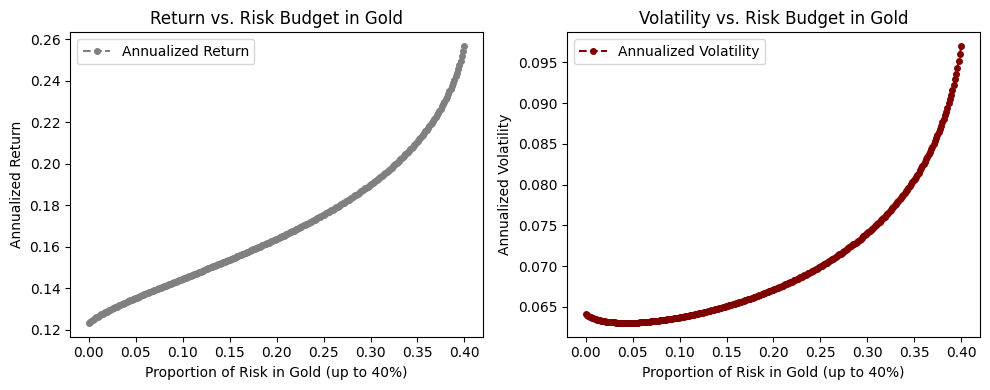

In [59]:
gold_risk_allocations = [res['GOLD_risk'] for res in results_GOLD]  # X-axis
retsGOLD             = [res['ret_annual'] for res in results_GOLD]
volsGOLD              = [res['vol_annual'] for res in results_GOLD]

plt.figure(figsize=(10, 4))

# Subplot: Return vs. Risk Allocation to BTC
plt.subplot(1, 2, 1)
plt.plot(gold_risk_allocations, retsGOLD, 'o--', label="Annualized Return", color='gray', markersize=4)
plt.xlabel('Proportion of Risk in Gold (up to 40%)')
plt.ylabel('Annualized Return')
plt.title('Return vs. Risk Budget in Gold')
plt.legend()

# Subplot: Volatility vs. Risk Allocation to BTC
plt.subplot(1, 2, 2)
plt.plot(gold_risk_allocations, volsGOLD, 'o--', color='maroon', label="Annualized Volatility" , markersize=4)
plt.xlabel('Proportion of Risk in Gold (up to 40%)')
plt.ylabel('Annualized Volatility')
plt.title('Volatility vs. Risk Budget in Gold')
plt.legend()

plt.tight_layout()
plt.show()


The plots illustrate how the portfolio’s annualized return and volatility evolve as the proportion of risk allocated specifically to Gold increases from 0% up to 40%, under a fixed risk allocation of 50% Equity, 10% Bitcoin, and a combined 40% for Bond and Gold. Initially, the portfolio’s risk budget for Gold was set to zero, and Bonds fully occupied the entire 40% risk allocation. Gradually, we increased the risk budget allocated to Gold while proportionally decreasing that of Bonds, keeping the Equity and Bitcoin allocations constant.

**The left-hand plot (“Annualized Return vs. Gold Risk Allocation”)** demonstrates that the portfolio’s annualized return steadily increases as the risk budget allocated to Gold grows. Initially, introducing Gold contributes modestly to returns, but as the risk allocation approaches its maximum of 40%, the portfolio return increases at an accelerating rate, suggesting Gold’s performance provided substantial incremental benefits during this period.

**The right-hand plot (“Annualized Volatility vs. Gold Risk Allocation”)** shows portfolio volatility as a function of Gold’s risk allocation. At lower levels of Gold allocation, the portfolio maintains relatively stable volatility. However, beyond approximately 20% of risk allocation to Gold, volatility sharply increases, reflecting Gold’s higher volatility compared to Bonds. This underscores a clear trade-off: increased allocation to Gold can significantly enhance returns but at the cost of substantially greater portfolio volatility.

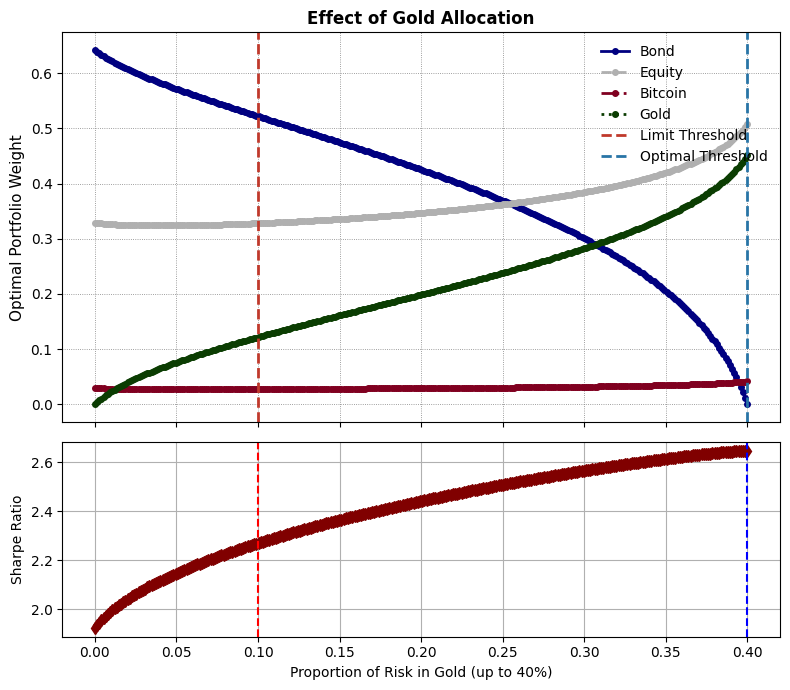


=== Optimal Sharpe Ratio Point (Gold) ===
Proportion of Risk in Gold: 0.4000
Maximum Sharpe Ratio: 2.6460
Asset allocation weights at Optimal Threshold:
  Bond: 0.0001%
  Equity: 50.7350%
  Bitcoin: 4.1580%
  Gold: 45.1068%

=== Limit Threshold (Gold risk = 10%) ===
Proportion of Risk in Gold: 0.1003
Sharpe Ratio at Limit Threshold: 2.2702
Asset allocation weights at Limit Threshold:
  Bond: 52.1744%
  Equity: 32.8103%
  Bitcoin: 2.8031%
  Gold: 12.2122%


In [60]:
weights_mat = np.array([res['weights_opt'] for res in results_GOLD])  # shape: (len(grid), 4)

# Calculate Sharpe Ratios
risk_free_rate = 0  
sharpe_ratios = [(ret - risk_free_rate) / vol for ret, vol in zip(retsGOLD, volsGOLD)]

# Thresholds
limit_threshold = 0.1  # Risk allocation limit
optimal_threshold_index = np.argmax(sharpe_ratios)  # Index of the maximum Sharpe ratio
optimal_threshold = gold_risk_allocations[optimal_threshold_index]  # Corresponding value

# Create figure and axes
fig, axs = plt.subplots(2, 1, figsize=(8, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

line_styles = ['-', '--', '-.', ':']  # Different line styles
colors = ["#000080", "#B0B0B0", "#800020", "#0B3D02"]

# Plot the evolution of optimal weights
for i, (asset, color, style) in enumerate(zip(assets, colors, line_styles)):
    axs[0].plot(gold_risk_allocations, weights_mat[:, i], marker='o', linestyle=style, 
                color=color, linewidth=2, label=asset, markersize=4)

# Customize the chart
axs[0].set_ylabel('Optimal Portfolio Weight', fontsize=11)
axs[0].set_title('Effect of Gold Allocation', fontsize=12, fontweight='bold')
axs[0].axvline(limit_threshold, color='#C0392B', linestyle='--', linewidth=2, label="Limit Threshold")  # Dark red
axs[0].axvline(optimal_threshold, color='#2874A6', linestyle='--', linewidth=2, label="Optimal Threshold")  # Refined blue
axs[0].legend(frameon=False, fontsize=10)
axs[0].grid(color="gray", linestyle=":", linewidth=0.6)
axs[0].tick_params(labelbottom=False)  # Hide X-axis labels on the top plot

# Plot the Sharpe Ratio
axs[1].plot(gold_risk_allocations, sharpe_ratios, 'd--', color='maroon', label="Sharpe Ratio")
axs[1].axvline(limit_threshold, color='red', linestyle='--', label="Limit Threshold")
axs[1].axvline(optimal_threshold, color='blue', linestyle='--', label="Optimal Threshold")
axs[1].set_xlabel('Proportion of Risk in Gold (up to 40%)')
axs[1].set_ylabel('Sharpe Ratio')

axs[1].grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

optimal_weights_gold = weights_mat[optimal_threshold_index]
optimal_sharpe_gold = sharpe_ratios[optimal_threshold_index]

print("\n=== Optimal Sharpe Ratio Point (Gold) ===")
print(f"Proportion of Risk in Gold: {optimal_threshold:.4f}")
print(f"Maximum Sharpe Ratio: {optimal_sharpe_gold:.4f}")
print("Asset allocation weights at Optimal Threshold:")
for asset, weight in zip(assets, optimal_weights_gold):
    print(f"  {asset}: {weight:.4%}")

limit_index_gold = np.argmin(np.abs(np.array(gold_risk_allocations) - limit_threshold))
limit_weights_gold = weights_mat[limit_index_gold]
limit_sharpe_gold = sharpe_ratios[limit_index_gold]

print("\n=== Limit Threshold (Gold risk = 10%) ===")
print(f"Proportion of Risk in Gold: {gold_risk_allocations[limit_index_gold]:.4f}")
print(f"Sharpe Ratio at Limit Threshold: {limit_sharpe_gold:.4f}")
print("Asset allocation weights at Limit Threshold:")
for asset, weight in zip(assets, limit_weights_gold):
    print(f"  {asset}: {weight:.4%}")

In [61]:
df_weights = pd.DataFrame(weights_mat, columns=assets)  # Use assets as column names
df_weights.insert(0, "Gold Risk Allocation", gold_risk_allocations)  # Add the allocation column
df_weights = df_weights.round(3)
df_weights = df_weights.set_index("Gold Risk Allocation")

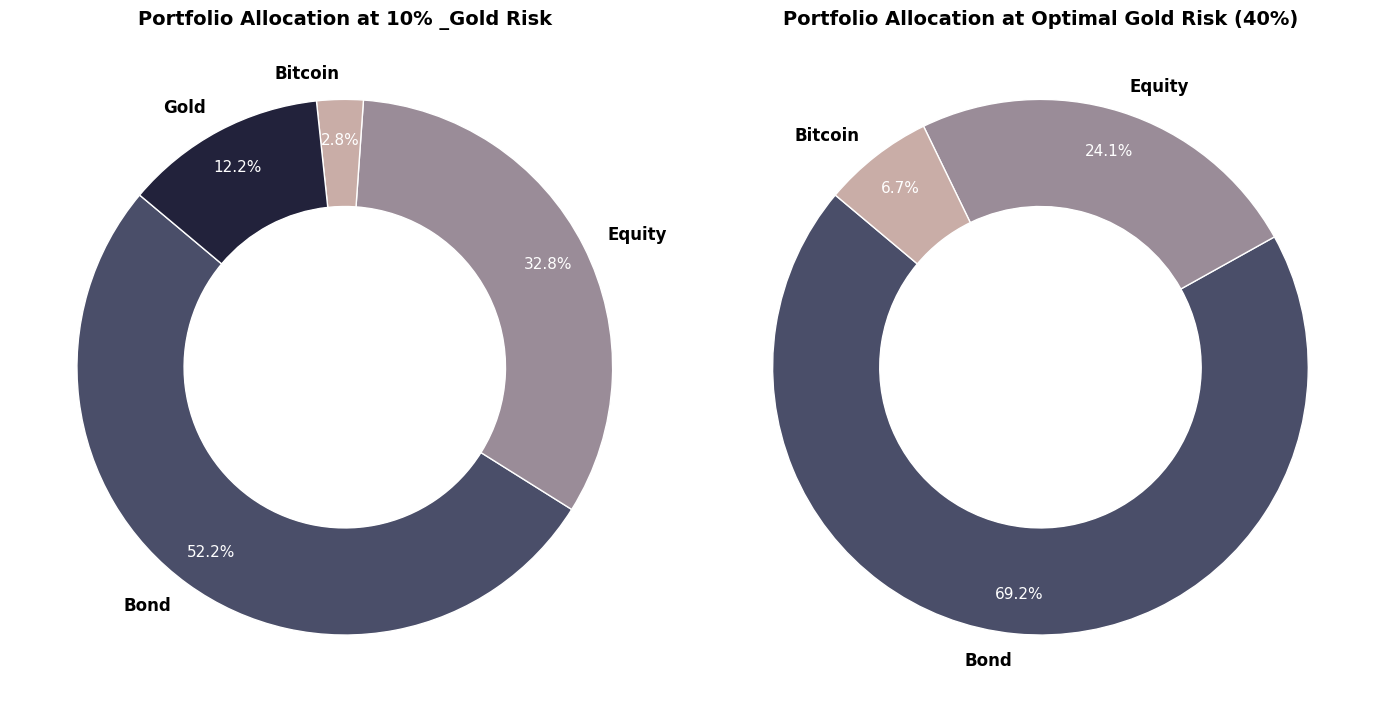

In [62]:
limit_row_data = df_weights.loc[0.1]
limit_row_data_nonzero = limit_row_data[limit_row_data > 0]

colors = ["#4A4E69", "#9A8C98", "#C9ADA7", "#22223B"]

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

wedges1, texts1, autotexts1 = axs[0].pie(
    limit_row_data_nonzero,
    labels=limit_row_data_nonzero.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='white'),
    pctdistance=0.85
)

axs[0].set_title("Portfolio Allocation at 10% _Gold Risk", fontsize=14, fontweight='bold')
plt.setp(texts1, fontsize=12, fontweight='bold')
plt.setp(autotexts1, fontsize=11, color='white')

centre_circle1 = plt.Circle((0, 0), 0.60, fc='white')
axs[0].add_artist(centre_circle1)

wedges2, texts2, autotexts2 = axs[1].pie(
    optimal_row_data_nonzero,
    labels=optimal_row_data_nonzero.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='white'),
    pctdistance=0.85
)

axs[1].set_title("Portfolio Allocation at Optimal Gold Risk (40%)", fontsize=14, fontweight='bold')
plt.setp(texts2, fontsize=12, fontweight='bold')
plt.setp(autotexts2, fontsize=11, color='white')

centre_circle2 = plt.Circle((0, 0), 0.60, fc='white')
axs[1].add_artist(centre_circle2)

plt.tight_layout()
plt.show()

This analysis explores how adjusting the risk budget allocated to Gold impacts portfolio composition and risk-adjusted returns, while keeping the risk allocation to Bitcoin fixed at 10% and Equity fixed at 50%. Specifically, we evaluate the effects of varying Gold’s risk contribution from 0% to 40%, thus correspondingly decreasing the risk budget initially allocated to Bonds from 40% down to 0%.

The first set of plots illustrates how the optimal weights for Bonds, Equity, Bitcoin, and Gold change as Gold’s risk contribution increases. Initially, Bonds dominate the portfolio due to their low volatility. However, as the risk allocated to Gold rises, the optimal weight shifts significantly from Bonds toward Gold and, to a lesser extent, Equity. Bitcoin’s allocation remains stable, reflecting its fixed risk budget. Two critical points are highlighted for comparison:

- **Limit Threshold (Gold risk = 10%)** The portfolio achieves a Sharpe Ratio of 2.2702, with allocations of approximately 52.17% Bonds, 32.81% Equity, 2.80% Bitcoin, and 12.21% Gold.

- **Optimal Threshold (Gold risk = 40%)**
The Sharpe Ratio peaks at 2.6460, with a significantly altered portfolio allocation—approximately 0.00% Bonds, 50.74% Equity, 4.16% Bitcoin, and 45.11% Gold.

The second visualization, featuring two donut charts, clearly illustrates asset distributions at these two thresholds, highlighting the shift toward greater Gold exposure to optimize portfolio performance. This analysis demonstrates that strategically increasing Gold’s risk allocation, given fixed contributions from Equity and Bitcoin, can notably enhance risk-adjusted returns, though it markedly changes the portfolio’s composition and increases its volatility.

# Optimum with Gold and BTC

In [63]:
df_weights = pd.DataFrame(weights_mat, columns=assets)  # Use assets as column names
df_weights.insert(0, "Gold Risk Allocation", gold_risk_allocations)  # Add the allocation column
df_weights = df_weights.round(3)
df_weights = df_weights.set_index("Gold Risk Allocation")

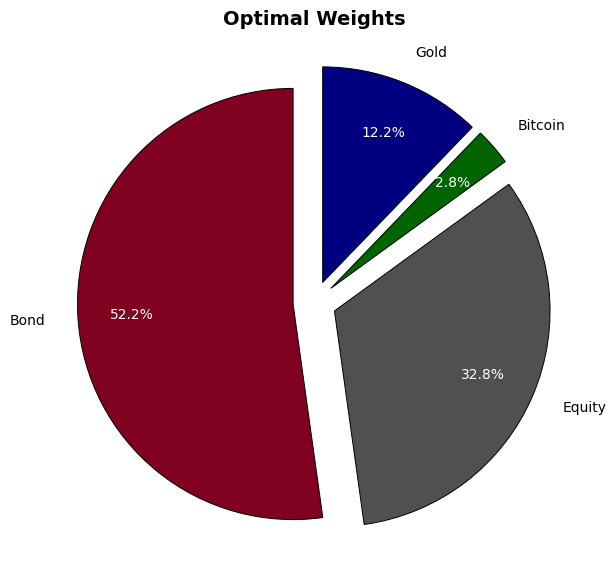

In [64]:
# Define custom colors (burgundy, dark gray, dark green, lighter blue)
colors = ["#800020", "#505050", "#006400", "#000080"]  # Lighter blue for better visibility

# Get the row where BTC Risk Allocation = 0.1
row_data = df_weights.loc[0.1]

# Threshold to highlight small sectors
small_threshold = 5  # If a sector is smaller than 5%, it is slightly separated
explode = [0.1 if value < small_threshold else 0 for value in row_data]

# Create a larger figure for better visibility
fig, ax = plt.subplots(figsize=(7, 7))

# Plot the pie chart with label adjustments
wedges, texts, autotexts = ax.pie(
    row_data,
    labels=row_data.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.7},  # Thinner borders
    pctdistance=0.75,  # Adjust percentage position closer to the center
    labeldistance=1.15,  # Move asset names outward
    explode=explode  # Separate small sectors
)

# Adjust text size for labels and percentages
for text in texts:
    text.set_fontsize(10)  # Reduce label size

for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color("white")  # Change percentage color to white

# Final configuration
ax.set_title("Optimal Weights", fontsize=14, fontweight='bold')
plt.ylabel("")  # Hide Y-axis label

# Show chart
plt.show()


The donut chart above displays the optimal asset allocation resulting from a risk-budgeting optimization approach, where both Bitcoin and Gold have fixed risk budgets of 10% each. Specifically, given risk budget targets of approximately 50% for Equity, 30% for Bonds (originally 40%, adjusted downward due to the 10% Gold allocation), 10% for Bitcoin, and 10% for Gold, the optimized allocation yields roughly 52.2% Bonds, 32.8% Equity, 12.2% Gold, and 2.8% Bitcoin. These results highlight the distinction between predefined risk budgets and actual optimized asset weights, reflecting each asset’s volatility and correlations within the portfolio.

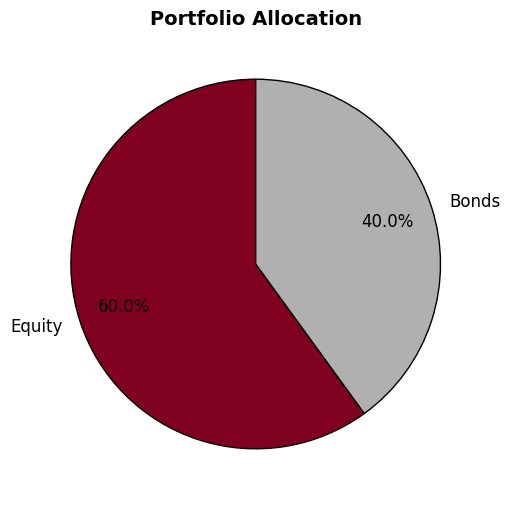

In [65]:
# Original Allocation

# Data
labels = ['Equity', 'Bonds']
sizes = [60, 40]
colors = ["#800020", "#B0B0B0"]  # Burgundy for Equity, Gray for Bonds

# Create figure
fig, ax = plt.subplots(figsize=(6, 6))

# Pie chart
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'black'},
    pctdistance=0.75,
    labeldistance=1.1
)

# Adjust font size
for text in texts:
    text.set_fontsize(12)  # Label size

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color("black")

# Title
ax.set_title("Portfolio Allocation", fontsize=14, fontweight='bold')

# Show chart
plt.show()


This pie chart illustrates the initial portfolio allocation used as the baseline for our analysis. Initially, we set the portfolio composition at 60% Equity and 40% Bonds, explicitly excluding Gold and Bitcoin from consideration. This original allocation serves as a foundational reference point, enabling comparison of how the introduction and risk-budget adjustments of additional assets (Bitcoin and Gold) subsequently influence the portfolio’s optimal weights and risk-adjusted returns.

# Results in sample


The optimal weights were selected using data in 2023 and 2024. The following chunk shows the results: the first row represents the original portfolio with 60% equity and 40% bonds, while the second row displays the optimal weights found using Risk Budgeting.

In [66]:
Metrics_df = pd.DataFrame()
Metrics_df["return"] = row_data[0] * df['r Bond']["2023":"2025"] + row_data[1] * df['r Equity']["2023":"2025"]  + row_data[2] * df['r Bitcoin']["2023":"2025"] + row_data[3] * df['r Gold']["2023":"2025"]  
Metrics_df.index = pd.to_datetime(Metrics_df.index)

optimal_portfolio= compute_metrics(Metrics_df, '60-40 / Equity-Bond')
portfolio_df = pd.concat([port_60_40_0_0, optimal_portfolio])
portfolio_df.index =["port_60_40_0_0", "Optimal"]
portfolio_df

/var/folders/7c/fms9v7rj3w3_ssh2tnrr_0t00000gn/T/ipykernel_89956/501612377.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Metrics_df["return"] = row_data[0] * df['r Bond']["2023":"2025"] + row_data[1] * df['r Equity']["2023":"2025"]  + row_data[2] * df['r Bitcoin']["2023":"2025"] + row_data[3] * df['r Gold']["2023":"2025"]


,Annualized Mean,Annualized Vol,Annualized Sharpe,Skew,Worst Month,Worst Month Return
port_60_40_0_0,0.15277,0.082303,1.856202,-0.178825,2023-09-30,-0.037412
Optimal,0.14458,0.063706,2.269491,-0.194922,2023-09-30,-0.028962


The table above compares the performance of two portfolios over the 2023–2024 in-sample period. The original portfolio, consisting of 60% Equity and 40% Bonds, exhibits a slightly higher annualized return (15.28%) compared to the optimized portfolio (14.46%). However, the optimized portfolio, obtained through Risk Budgeting optimization and including Bitcoin and Gold, significantly outperforms in terms of risk-adjusted returns, as evidenced by its notably higher Sharpe Ratio (2.27 versus 1.86). Moreover, the optimized portfolio demonstrates lower volatility (6.37% versus 8.23%) and improved resilience during adverse market conditions, as seen from its better worst-month performance (-2.90% compared to -3.74%). Overall, the Risk Budgeting approach results in a portfolio that, despite slightly lower returns, achieves superior performance by effectively reducing risk and enhancing stability.

# Results out sample

The following chunk shows the returns from start of 2025 up to now after applying the optimal weights calculated with 2023&2024 data, that is, Out of Sample.

In [67]:
Metrics_df = pd.DataFrame()
Metrics_df["return"] = row_data[0] * df['r Bond']["2025":] + row_data[1] * df['r Equity']["2025":]  + row_data[2] * df['r Bitcoin']["2025":] + row_data[3] * df['r Gold']["2025":]  
Metrics_df.index = pd.to_datetime(Metrics_df.index)

optimal_portfolio_2024= compute_metrics(Metrics_df, '60-40 / Equity-Bond')
portfolio_df_2024 = pd.concat([port_60_40_0_0_2025, optimal_portfolio_2024])
portfolio_df_2024.index =["port_60_40_0_0", "Optimal"]
portfolio_df_2024

/var/folders/7c/fms9v7rj3w3_ssh2tnrr_0t00000gn/T/ipykernel_89956/2062161373.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Metrics_df["return"] = row_data[0] * df['r Bond']["2025":] + row_data[1] * df['r Equity']["2025":]  + row_data[2] * df['r Bitcoin']["2025":] + row_data[3] * df['r Gold']["2025":]


,Annualized Mean,Annualized Vol,Annualized Sharpe,Skew,Worst Month,Worst Month Return
port_60_40_0_0,0.074461,0.161341,0.461516,1.081603,2025-03-31,-0.032781
Optimal,0.112751,0.100231,1.124911,1.360602,2025-03-31,-0.011551


The table above demonstrates the out-of-sample performance (from early 2025 to now) of two portfolios: the original portfolio with a fixed allocation of 60% Equity and 40% Bonds, and an optimized portfolio whose asset weights (including Bitcoin and Gold) were derived from the risk-budgeting optimization conducted using 2023–2024 data.

The optimized portfolio significantly outperforms the original portfolio across all key metrics. It achieves a notably higher annualized return (11.28% versus 7.45%) and substantially reduces volatility (10.02% compared to 16.13%). Consequently, the optimized portfolio delivers a markedly superior Sharpe Ratio (1.1249 versus 0.4615), indicating enhanced risk-adjusted returns. Moreover, the optimized portfolio demonstrates greater resilience during downturns, with the worst monthly return notably improved (-1.16% versus -3.28%). This out-of-sample validation confirms that the risk-budgeting approach provides robust improvements in both return and risk management, effectively enhancing portfolio performance in realistic market conditions.